# Applying Logistic regression to 2 layer QG
See `simple_run2.ipynb` and `rare_statistics.ipynb` for more details

## Modules import
First, setting the path and loading of some modules

In [32]:

import sys, os
sys.path.extend([os.path.abspath('../')])
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Times'],'size':14})

np.random.seed(1234) # Initializing the random number generator (for reproducibility). -- Disable if needed.

from qgs.params.params import QgParams #Importing the model's modules
from qgs.integrators.integrator import RungeKuttaIntegrator, RungeKuttaTglsIntegrator
from qgs.functions.tendencies import create_tendencies
from qgs.plotting.util import std_plot

from qgs.diagnostics.streamfunctions import MiddleAtmosphericStreamfunctionDiagnostic # and diagnostics
from qgs.diagnostics.variables import VariablesDiagnostic
from qgs.diagnostics.multi import MultiDiagnostic

from qgs.diagnostics.temperatures import GroundTemperatureDiagnostic
from qgs.diagnostics.temperatures import MiddleAtmosphericTemperatureDiagnostic

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
#### Custom Metrics ######

class UnbiasedMetric(keras.metrics.Metric):
    def __init__(self, name, undersampling_factor=1, **kwargs):
        super().__init__(name=name, **kwargs)
        self.undersampling_factor = undersampling_factor
        self.r = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)

    
class MCCMetric(UnbiasedMetric): # This function is designed to produce confusion matrix during training each epoch
    def __init__(self, num_classes=2, threshold=None, undersampling_factor=1, name='MCC', **kwargs):
        '''
        Mathews correlation coefficient metric

        Parameters
        ----------
        num_classes : int, optional
            number of classes, by default 2
        threshold : float, optional
            If num_classes == 2 allows to choose a threshold over which to consider an event positive. If None the event is positive if it has probability higher than 0.5. By default None
        '''
        super().__init__(name=name, undersampling_factor=undersampling_factor, **kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.threshold = threshold
        if self.num_classes != 2:
            raise NotImplementedError('MCC works only with 2 classes')
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
    
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
    
    @tf.autograph.experimental.do_not_convert
    def result(self):
        #return self.process_confusion_matrix()
        cm=self.total_cm
        
        #return cm
        TN = cm[0,0]
        FP = cm[0,1]
        FN = cm[1,0]
        TP = cm[1,1]
        MCC_den = ((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
        MCC = (TP * TN - FP *FN)/tf.sqrt(MCC_den)
        return tf.cond(MCC_den == 0, lambda: tf.constant(0, dtype=tf.float32), lambda: MCC)
    
    def confusion_matrix(self,y_true, y_pred): # Make a confusion matrix
        if self.undersampling_factor > 1 or self.threshold is not None:
            y_pred = keras.layers.Softmax()(y_pred + self.r) # apply shift of logits and softmax to convert to balanced probabilities
        if self.threshold is None:
            y_pred=tf.argmax(y_pred,1)
        else:
            y_pred = tf.cast(y_pred[:,1] > self.threshold, tf.int8)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def fill_output(self,output):
        results=self.result()
        
class ConfusionMatrixMetric(UnbiasedMetric): # This function is designed to produce confusion matrix during training each epoch
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, num_classes, undersampling_factor=1, name='confusion_matrix', **kwargs):
        super().__init__(name=name, undersampling_factor=undersampling_factor, **kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        #return self.process_confusion_matrix()
        cm=self.total_cm
        return cm
    
    def confusion_matrix(self,y_true, y_pred): # Make a confusion matrix
        if self.undersampling_factor > 1:
            y_pred = keras.layers.Softmax()(y_pred + self.r) # apply shift of logits and softmax to convert to balanced probabilities
        
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def fill_output(self,output):
        results=self.result()

class BrierScoreMetric(UnbiasedMetric):
    def __init__(self, undersampling_factor=1, name='BrierScore', **kwargs):
        super().__init__(name=name, undersampling_factor=undersampling_factor, **kwargs)
        self.mse = keras.metrics.MeanSquaredError()
        self.my_metric = self.add_weight(name='BScore', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        _ = self.mse.update_state(y_true, keras.layers.Softmax()(y_pred + self.r))
        self.my_metric.assign(self.mse.result())

    def result(self):
        return self.my_metric

class UnbiasedCrossentropyMetric(UnbiasedMetric):

  def __init__(self, undersampling_factor=1, name='UnbiasedCrossentropy', **kwargs):
    super().__init__(name=name, undersampling_factor=undersampling_factor, **kwargs)
    self.my_metric = self.add_weight(name='CLoss', initializer='zeros')
    self.m = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)

  def update_state(self, y_true, y_pred, sample_weight=None):
    #_ = self.m.update_state(tf.cast(y_true, 'int32'), y_pred)
    _ = self.m.update_state(y_true, y_pred+self.r) # the idea is to add the weight factor inside the logit so that we effectively change the probabilities
    self.my_metric.assign(self.m.result())
    
  def result(self):
    return self.my_metric


# same as above but less elegant
class CustomLoss(tf.keras.metrics.Metric):

  def __init__(self, r, name='CustomLoss', **kwargs):
    super().__init__(name=name, **kwargs)
    self.my_metric = self.add_weight(name='CLoss', initializer='zeros')
    self.r = r # undersampling_factor array (we expect the input as tf.cast(-0.5*np.log(undersampling_factor), 0.5*np.log(undersampling_factor))
    self.m = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)


  def update_state(self, y_true, y_pred, sample_weight=None):
    #_ = self.m.update_state(tf.cast(y_true, 'int32'), y_pred)
    _ = self.m.update_state(y_true, y_pred+self.r) # the idea is to add the weight factor inside the logit so that we effectively change the probabilities
    self.my_metric.assign(self.m.result())
    
  def result(self):
    return self.my_metric

  """ 
  def reset_states(self):
    # The state of the metric will be reset at the start of each epoch.
    self.my_metric.assign(0.) 
  """

class UnbiasedCrossentropyLoss(keras.losses.SparseCategoricalCrossentropy):
    '''
    This is the same as the UnbiasedCrossentropyMetric but can be used as a loss
    '''
    def __init__(self, undersampling_factor=1, name='unbiased_crossentropy_loss'):
        super().__init__(from_logits=True, name=name)
        self.r = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)

    def __call__(self, y_true, y_pred, sample_weight=None):
        return super().__call__(y_true, y_pred + self.r)

class MyMetrics_layer(tf.keras.metrics.Metric):

  def __init__(self, name='MyMetrics_layer', **kwargs):
    super(MyMetrics_layer, self).__init__(name=name, **kwargs)
    self.my_metric = self.add_weight(name='my_metric1', initializer='zeros')
    self.m = tf.keras.metrics.SparseCategoricalAccuracy()


  def update_state(self, y_true, y_pred, sample_weight=None):
    _ = self.m.update_state(tf.cast(y_true, 'int32'), y_pred)
    self.my_metric.assign(self.m.result())
    
  def result(self):
    return self.my_metric

  def reset_states(self):
    # The state of the metric will be reset at the start of each epoch.
    self.my_metric.assign(0.)
"""
class CustomLoss(tf.keras.metrics.Metric):

  def __init__(self, name='custom_loss', **kwargs):
    super(CustomLoss, self).__init__(name=name, **kwargs)
    #self.custom_loss = self.add_weight(name='closs', initializer='zeros')
    self.scce=tf.keras.losses.SparseCategoricalCrossentropy()#from_logits=True), #If the predicted labels are not converted to a probability distribution by the last layer of the model (using sigmoid or softmax activation functions), we need to inform these t

  def update_state(self, y_true, y_pred, sample_weight=None):
    update_state_out = self.scce(y_true,y_pred)
    update_state_out = y_true.shape
    self.custom_loss.assign_add(update_state_out)

  def result(self):
    #return self.custom_loss
    return self.scce(y_true,y_pred)
"""

def create_Logistic(model_input_dim, regularizer='l2', regularizer_coef=1e-9):
    inputs = keras.Input(shape=model_input_dim) # Create a standard model (alternatively we can use our function my_create_logistic_model which builds a custom sequential model
    x = tf.keras.layers.Flatten(input_shape=model_input_dim)(inputs)
    if regularizer == 'none':
        outputs = tf.keras.layers.Dense(2)(x)
    elif regularizer == 'l2':
        outputs = tf.keras.layers.Dense(2, kernel_regularizer=regularizers.l2(regularizer_coef))(x)
    else:
        outputs = tf.keras.layers.Dense(2, kernel_regularizer=regularizers.l1(regularizer_coef))(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)   # alternatively we can write:     model = MyModel(inputs=inputs, outputs=outputs)
    return model

def ComputeTimeAverage(series,T=14*18,tau=0, percent=5, threshold=None): 
        '''
        Computes running mean from time series
        '''
        print(f'{T = }')
        convseq = np.ones(T)/T
        A=np.convolve(series,  convseq, mode='valid')
        if threshold is None:
            threshold = np.sort(A)[np.ceil(A.shape[0]*(1-percent/100)).astype('int')]
        list_extremes = list(A >= threshold)
        print(f'{len(list_extremes) = }')
        return A, threshold, list_extremes, convseq

## Systems definition
#General parameters. I am selecting standard parameters for the runs below, not sure if this is what Robin is using
# Time parameters
dt = 0.1
# Saving the model state n steps
write_steps = 5

number_of_trajectories = 1
number_of_perturbed_trajectories = 10

#The other parameters can come from model1.pickle that Robin prepared:
import pickle
# loading the model
with open('model1.pickle', "rb") as file:
    model = pickle.load(file)

f = model['f']
Df = model['Df']
model_parameters = model['parameters']
# Printing the model's parameters
model_parameters.print_params()

#Why did Robin choose n = 0.353? Otherwise the setup is similar to ground_heat.ipynb but with more spectral components. It is not clear to me if we need many spectral components. The typical setup with fewer components is usually enough to provide some realism. 

#Parameters that are different:
#* Atmospheric Temperature parameters
#    * 'C[1]' : 122 [W][m^-2] instead of 99 [W][m^-2]: (spectral component 1 of the short-wave radiation of the atmosphere), other C's are zero
#    * 'hlambda': 20  [W][m^-2][K^-1] instead of 10 [W][m^-2][K^-1] (sensible+turbulent heat exchange between ocean and atmosphere),
#* Ground Parameters:
#    * 'hk[2]': 0.4 instead of 0.2    (spectral components 2 of the orography), other h'k are zero
#* Ground Temperature Parameters:
#    * 'gamma': 200000000  [J][m^-2][K^-1] instead of 16000000  (specific heat capacity of the ground),
#    * 'C[1]': 280.0  [W][m^-2]  (spectral component 1 of the short-wave radiation of the ground), other C parameters are zero
#Below we can also investigate what fields that are actually used 
# model_parameters.latex_var_string

# Now we create the test and train trajectories.

f, Df, ic, time, reference_traj, reference_time, MiddleT, psi, groundT, timedimensional, A, threshold, list_extremes = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}
for sample_set in ['tr','va']:
    trajfilename = f'traj_{sample_set}.pickle' # to create new trajectories rename the file or remove it form the directory
    if not os.path.exists(trajfilename): 
        f[sample_set], Df[sample_set] = create_tendencies(model_parameters)
        print('tendencies created')
        ## Time integration
        #Defining an integrator
        integrator = RungeKuttaIntegrator()
        integrator.set_func(f[sample_set])
        #Start on a random initial condition and integrate over a transient time to obtain an initial condition on the attractors. I kept the standard time that is typically used in other runs, so not sure if it perfectly adapted...
        print('integrator set up')
        ic[sample_set] = np.random.rand(model_parameters.ndim)*0.1
        integrator.integrate(0., 500000., dt, ic=ic[sample_set], write_steps=0) # actually 200000 should be enought according to rare_statistics.ipynb
        time[sample_set], ic[sample_set] = integrator.get_trajectories()
        print('done generating initial coordinates')

        #Now integrate to obtain a trajectory on the attractor
        integrator.integrate(0., 500000., dt, ic=ic[sample_set], write_steps=write_steps)
        reference_time[sample_set], reference_traj[sample_set] = integrator.get_trajectories()
        print(f'saving {trajfilename}')
        with open(trajfilename, 'wb') as file:
            pickle.dump([ic[sample_set],reference_time[sample_set],reference_traj[sample_set]], file)
    else:
        print(f'loading {trajfilename}')
        with open(trajfilename, "rb") as file:
            [ic[sample_set],reference_time[sample_set],reference_traj[sample_set]] = pickle.load(file)


    MiddleT[sample_set] = MiddleAtmosphericTemperatureDiagnostic(model_parameters, True)
    psi[sample_set] = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters, geopotential=True)
    groundT[sample_set] = GroundTemperatureDiagnostic(model_parameters, True)

    for field in [psi[sample_set],groundT[sample_set],MiddleT[sample_set]]:
        field.set_data(reference_time[sample_set], reference_traj[sample_set])
        field.climatology = np.mean(field.diagnostic,0)
        field.std = np.std(field.diagnostic,0)
        field.anomaly = field.diagnostic - field.climatology
        
    x, y = 9, 9
    timedimensional[sample_set] = groundT[sample_set]._time*groundT[sample_set]._model_params.dimensional_time

    A[sample_set], threshold[sample_set], list_extremes[sample_set], convseq = ComputeTimeAverage(groundT[sample_set].anomaly[:,x, y],T=18*14*10)
    print(f'{threshold[sample_set] = }, {np.sum(list_extremes[sample_set])/len(list_extremes[sample_set]) = }')

for field in [psi[sample_set],groundT[sample_set],MiddleT[sample_set]]:
    field.extmean = np.mean(field.anomaly[np.where(np.array(list_extremes[sample_set]) == True)[0],...],0)
    field.extstd = np.std(field.anomaly[np.where(np.array(list_extremes[sample_set]) == True)[0],...],0)

/home/scratch01/gmiloshe/tests/qgs/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
  warnings.warn("Parameter configured to perform dimensional conversion " +


Qgs v0.2.5 parameters summary

General Parameters:
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 0.353    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.25    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.1  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.01  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'gamma': 10000000.0  [J][m^-2][K^-1]  (specific heat capacity of the atmosphere),
'C[1]': 112.0  [W][m^-2]  (spectral component 1 of the short-wave radiation of t

I was wondering if I am actually on the attractor when the simulation starts

In [33]:
threshold

{'tr': 1.517076649333899, 'va': 1.568970531335691}

We plot the climatology of middle atmosphere geopotential along with the composite map conditioned to 5 percent extremes

/tmp/ipykernel_4924/1601058816.py:8: UserWarning: The following kwargs were not used by contour: 'linewdiths'
  cs1 = axs[0,iter].contour(field._X, field._Y, field.std, colors='black', linewdiths=5) #, cmap="Greens")
/tmp/ipykernel_4924/1601058816.py:9: UserWarning: The following kwargs were not used by contour: 'linewdiths'
  cs2 = axs[0,iter].contour(field._X, field._Y, field.std, colors='white', linewdiths=.5) #, cmap="Greens")


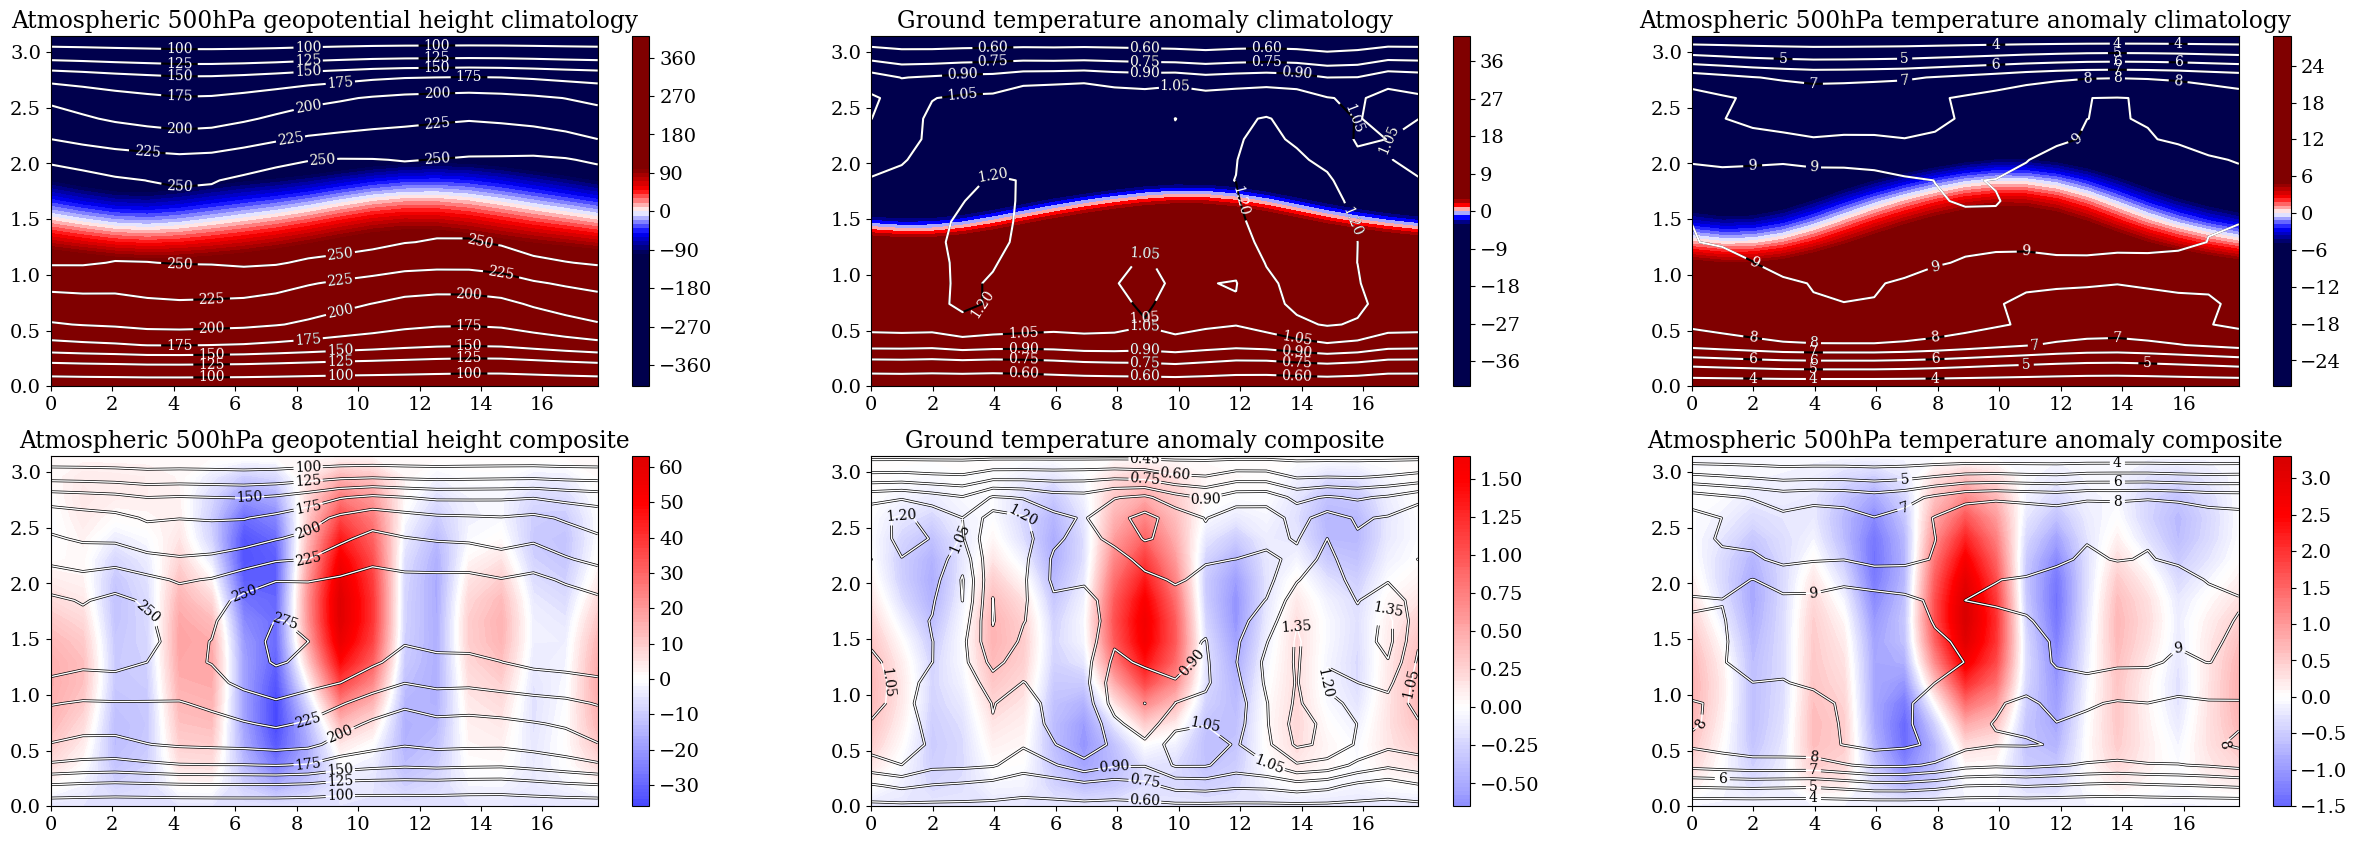

In [34]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30,10),constrained_layout=False)


for iter, field_margin, field in zip(range(3),[100,3,5],[psi['tr'],groundT['tr'],MiddleT['tr']]):
    field.extmean = np.mean(field.anomaly[np.where(np.array(list_extremes['tr']) == True)[0],...],0)
    field.extstd = np.std(field.anomaly[np.where(np.array(list_extremes['tr']) == True)[0],...],0)
    cs0 = axs[0,iter].contourf(field._X, field._Y, field.climatology, cmap="seismic", levels=100, vmin=-field_margin, vmax=field_margin)
    cs1 = axs[0,iter].contour(field._X, field._Y, field.std, colors='black', linewdiths=5) #, cmap="Greens")
    cs2 = axs[0,iter].contour(field._X, field._Y, field.std, colors='white', linewdiths=.5) #, cmap="Greens")
    axs[0,iter].clabel(cs1, inline=True, fontsize=10)
    axs[0,iter].clabel(cs2, inline=True, fontsize=10)
    fig.colorbar(cs0, ax=axs[0,iter])
    axs[0,iter].set_title(field._plot_title+' climatology')

    cs0 = axs[1,iter].contourf(field._X, field._Y, field.extmean, cmap="seismic", levels=100, vmin=-field_margin, vmax=field_margin)
    cs1 = axs[1,iter].contour(field._X, field._Y, field.extstd, colors='black', linewidths=2) #, cmap="Greens")
    cs12 = axs[1,iter].contour(field._X, field._Y, field.extstd, colors='white', linewidths=1) #, cmap="Greens")
    axs[1,iter].clabel(cs1, inline=True, fontsize=10)
    axs[1,iter].clabel(cs2, inline=True, fontsize=10)
    fig.colorbar(cs0, ax=axs[1,iter])
    axs[1,iter].set_title(field._plot_title+' composite')
plt.show()

We will first work with ground temperature (to predict ground temperature). We setup the model as follows, including subtracting the mean and dividing by standard deviation

In [35]:
groundT['tr'].std_regularized = groundT['tr'].std[groundT['tr'].std==0] = 1 # If there is no variance we shouldn't divide by zero
X_tr = (groundT['tr'].diagnostic[:len(list_extremes['tr']),...] - groundT['tr'].climatology/groundT['tr'].std_regularized)
y_tr = np.array(list_extremes['tr'])
X_va = (groundT['va'].diagnostic[:len(list_extremes['va']),...] - groundT['tr'].climatology/groundT['tr'].std_regularized)
y_va = np.array(list_extremes['va'])

model_input_dim = X_tr.shape[1:] #(X.shape[1],X.shape[2])
#model = create_regularized_model(1e-5, 1)
model = create_Logistic(model_input_dim, regularizer='l2', regularizer_coef=1e-9)

print("model_input_dim = ",model_input_dim)

undersampling_factor=1

tf_sampling = tf.cast([0.5*np.log(undersampling_factor), -0.5*np.log(undersampling_factor)], tf.float32)
model.summary()
#METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2)]   # the last two make the code run longer but give precise discrete prediction benchmarks
METRICS=['accuracy',MCCMetric(2),ConfusionMatrixMetric(2),CustomLoss(tf_sampling)]#tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True)]#CustomLoss()]   # the last two make the code run longer but give precise discrete prediction benchmarks
#METRICS=['loss']
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 2e-4),
    #optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), #If the predicted labels are not converted to a probability distribution by the last layer of the model (using sigmoid or softmax activation functions), we need to inform these three Cross-Entropy functions by setting their from_logits = True.
    #One advantage of using sparse categorical cross-entropy is it saves storage in memory as well as time in computation because it simply uses a single integer for a class, rather than a whole one-hot vector. This works despite the fact that the neural network has an one-hot vector output  
    metrics=METRICS   # the last two make the code run longer but give precise discrete prediction benchmarks
)
model_name='test'
checkpoint_path = model_name+"/cp-{epoch:04d}.ckpt"
       
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1)


model.save_weights(checkpoint_path.format(epoch=0))


model_input_dim =  (18, 19)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 18, 19)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 342)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 686       
                                                                 
Total params: 686
Trainable params: 686
Non-trainable params: 0
_________________________________________________________________


In [36]:
def probability_model(inputs,input_model): # This function is used to apply softmax to the output of the neural network
    x = input_model(inputs)
    outputs = layers.Softmax()(x)
    return keras.Model(inputs, outputs)
my_history=model.fit(X_tr, y_tr, batch_size=128, validation_data=(X_va,y_va), shuffle=True, callbacks=[cp_callback], epochs=10,verbose=2, class_weight=None)

model.save(model_name)
np.save(model_name+'_history.npy',my_history.history)

my_probability_model=(tf.keras.Sequential([ # softmax output to make a prediction
    model,
    tf.keras.layers.Softmax()
]))


2022-10-10 18:10:11.771760: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1364555376 exceeds 10% of free system memory.


Epoch 1/10


2022-10-10 18:10:43.995813: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1364555376 exceeds 10% of free system memory.
/home/users/gmiloshe/.conda/envs/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric MCCMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
/home/users/gmiloshe/.conda/envs/qgs/lib/python3.8/site-packages/keras/engine/training.py:2319: UserWarning: Metric ConfusionMatrixMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: saving model to test/cp-0001.ckpt
7793/7793 - 25s - loss: 0.3285 - accuracy: 0.9224 - MCC: 0.2390 - confusion_matrix: 249370.5000 - CustomLoss: 0.3285 - val_loss: 0.1910 - val_accuracy: 0.9515 - val_MCC: 0.2050 - val_confusion_matrix: 249370.5000 - val_CustomLoss: 0.1910 - 25s/epoch - 3ms/step
Epoch 2/10

Epoch 2: saving model to test/cp-0002.ckpt
7793/7793 - 17s - loss: 0.1361 - accuracy: 0.9579 - MCC: 0.3974 - confusion_matrix: 249370.5000 - CustomLoss: 0.1361 - val_loss: 0.1561 - val_accuracy: 0.9484 - val_MCC: 0.2582 - val_confusion_matrix: 249370.5000 - val_CustomLoss: 0.1561 - 17s/epoch - 2ms/step
Epoch 3/10

Epoch 3: saving model to test/cp-0003.ckpt
7793/7793 - 17s - loss: 0.1221 - accuracy: 0.9589 - MCC: 0.4366 - confusion_matrix: 249370.5000 - CustomLoss: 0.1221 - val_loss: 0.1585 - val_accuracy: 0.9435 - val_MCC: 0.2517 - val_confusion_matrix: 249370.5000 - val_CustomLoss: 0.1585 - 17s/epoch - 2ms/step
Epoch 4/10

Epoch 4: saving model to test/cp-0004.ckpt
7793/779